# Integration methods comparison

In [1]:
import stagem1.temporal_integration as sti
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

## Error estimation
Advancement ($=x(a,t)-x(a,t=0)$) are computed for all particules with the different integration methods: Euler, RK2, RK4 with a 30 min simulation time step, and RK4 with a 3h simulation time step. These advancements are then compared (simple difference) with the advancement computed by RK4 with a simulation time step of 10 min. We assume that this short time step linked with the RK4 method allow us to consider this as the reference: it will approachs the analytical answer that we can't compute. 

The error calculated by Euler in case: $U(t)=u_w cos(wt+\phi) + u_m$, i.e`k=0`, `advected=0` (unadvected) is :
$$\alpha = \frac{ u_w  t_{step}}{2}(cos(\phi)-cos(wt+\phi)) - \frac{w*u_w*t_{step}²}{6}(sin(wt+\phi)-sin(\phi)))$$ with $t_{step}$ the simulation time step.

With general wave parameters, $u_w=0.1, w\frac{2*\pi}{12*3600}$:  
$\frac{w*u_w*t_{step}²}{6}~8m << \frac{ u_w  t_{step}}{2}=90m$ so the second term can be neglected in first approximation.

### Test with `k=0` (-> $\phi=0$), `uw=0.1`, `w=w2=2*np.pi/(12*3600)`

For Euler method the error at order 1 is : $\alpha=|90*(1-cos(w2*t))|$.  


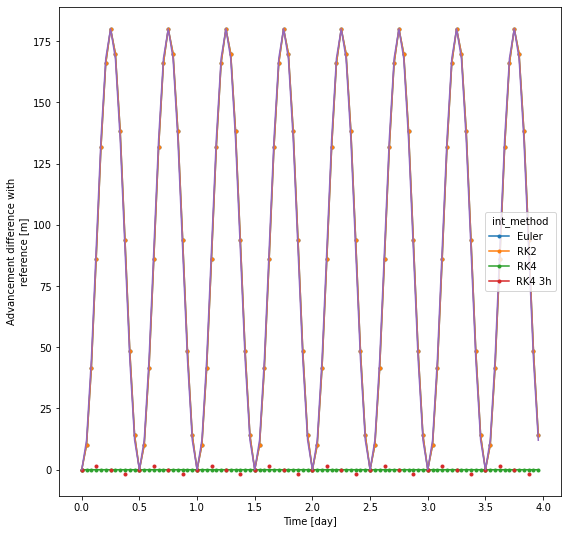

In [18]:
x=sti.SetUp(advected=0, k=0, um=0)# um=1, uw=0.5, advected=0)
comp=sti.Temp_Int_Comp(x, advected=0, k=0, um=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
comp.print_diff_adv()
t=x.out_ds.otime
err=x['uw']*sti.h2s/2/2*(1-xr.ufuncs.cos(x['w']*t))
err.attrs={'units':'m', "long_name":"Advancement difference with reference"}
err.plot(x='otime_day')




* Euler and RK2 are confused.
* the error calculed via the formula is added (in purple). It perfectly fits the computed error.

### Test with `k=k2` (i.e wavelenght=100km) unadvected
We take back the normal case with `k=k2` to see if the precedent error formula is still relevent.
The first plot represents the difference between advancement of each method and the reference advancement.
Other plots represents the advancement average on particules, thus on initial phase, and the absolute difference of advancement also average on particules.

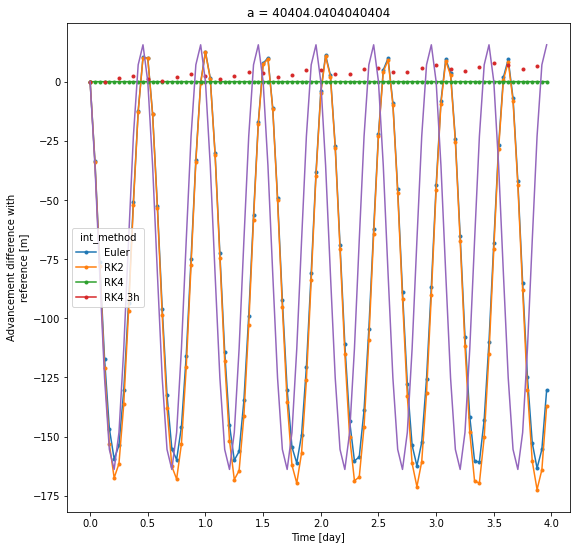

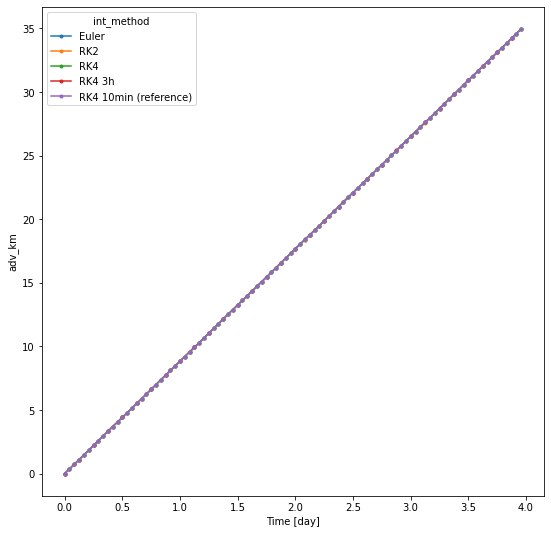

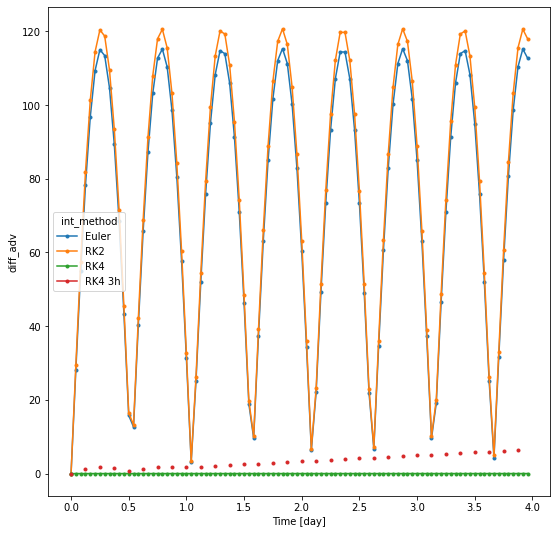

In [13]:
y=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compy=sti.Temp_Int_Comp(y,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compy.print_diff_adv()
t=y.out_ds.otime
yp=y['p'].isel(a=20)
y0=y['p'].isel(a=20, otime=0)
err=y['uw']*sti.h2s/2/2*(xr.ufuncs.cos(y['k']*y0)-xr.ufuncs.cos(y['w']*t-y['k']*y0))
err.attrs={'units':'m', "long_name":"Advancement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day')
compy.print_diff_adv_mean()


* The first print shows that `k=k2` does not impact so much the amplitude which is still around 90.  Difference with last section appear to correspond to a change of $\phi$ in error formula. It fits pretty well taking $\phi=kx(t=0)$ added in purple (average value = $90*cos(\phi)=90*cos(\phi_0) = 90*cos(k2*40404)=-74$).
* We can nevertheless notice a slight increase in average value (in reality $\phi=kx(t)$ increases with t ?)
* k seems to have also  an influence on error periodicity (extend it? how much?).  
* Last print shows that the absolute value and the average on particules erase a part of the amplitude (not the accurate method to study error ? ).
Indeed, $k_2*35*km=2.2 << w_2*4 jours=50$.  
  
Let's try with $\phi= kx(t)$:

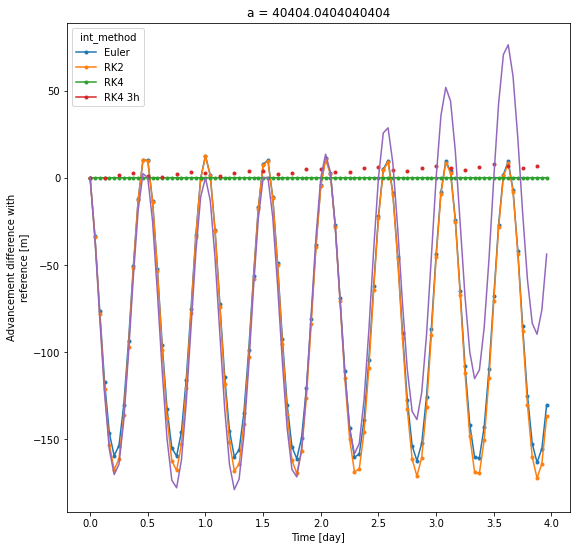

In [16]:
y=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compy=sti.Temp_Int_Comp(y,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compy.print_diff_adv()
t=y.out_ds.otime
yp=y['p'].isel(a=20)
y0=y['p'].isel(a=20, otime=0)
err=y['uw']*sti.h2s/2/2*(xr.ufuncs.cos(y['k']*yp)-xr.ufuncs.cos(y['w']*t-y['k']*yp))
err.attrs={'units':'m', "long_name":"Advancement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day')

This corrects the periodicity shift but worsenes the average value gap.  

So let's try with $\phi=kx(t=0)$ in the average value term and $\phi=kx(t)$ in the oscillated term:

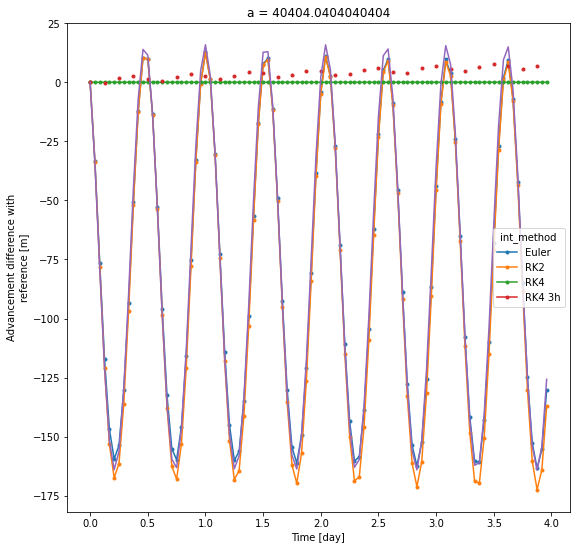

In [35]:
y=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compy=sti.Temp_Int_Comp(y,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compy.print_diff_adv(traj=20)
t=y.out_ds.otime
yp=y['p'].isel(a=20)
y0=y['p'].isel(a=20, otime=0)
err=y['uw']*sti.h2s/2/2*(xr.ufuncs.cos(y['k']*y0)-xr.ufuncs.cos(y['w']*t-y['k']*yp))
err.attrs={'units':'m', "long_name":"Advancement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day')

This appears to be the best approximation of the error.  
Let's try for an other trajectory:

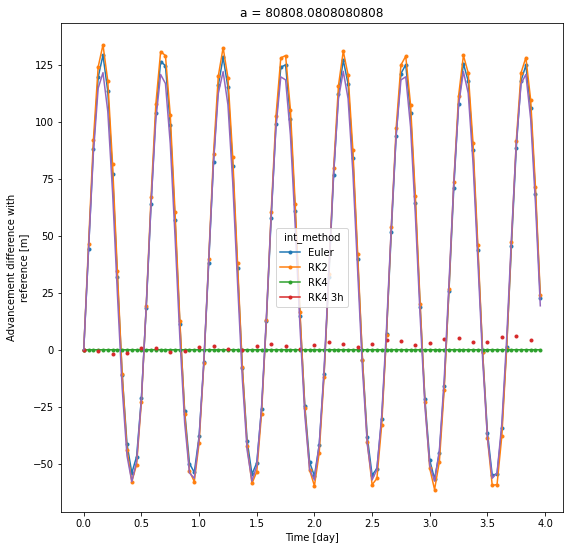

In [39]:
z=sti.SetUp(advected=0)
compz=sti.Temp_Int_Comp(z,advected=0)
compz.print_diff_adv(traj=40)
t=z.out_ds.otime
zp=z['p'].isel(a=40)
z0=z['p'].isel(a=40, otime=0)
err=z['uw']*sti.h2s/2/2*(xr.ufuncs.cos(z['k']*z0)-xr.ufuncs.cos(z['w']*t-z['k']*zp))
err.attrs={'units':'m', "long_name":"Advancement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day')

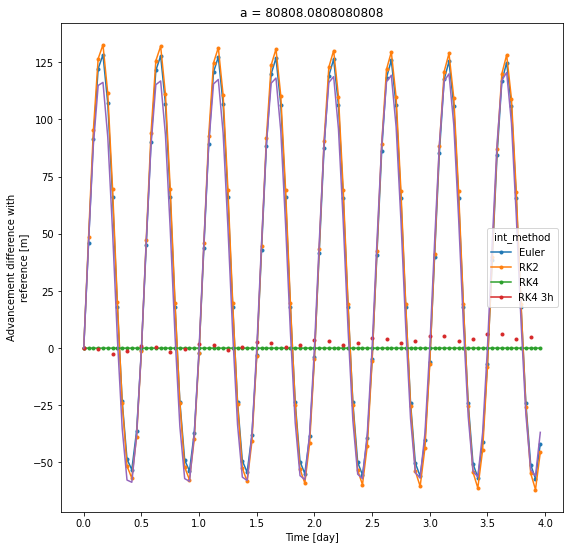

In [20]:
z=sti.SetUp()
compz=sti.Temp_Int_Comp(z)
compz.print_diff_adv(traj=40)
t=z.out_ds.otime
zp=z['p'].isel(a=40)
z0=z['p'].isel(a=40, otime=0)
err=z['uw']*sti.h2s/2/2*(xr.ufuncs.cos(z['k']*(zp-z['um']*t))-xr.ufuncs.cos(z['w']*t-z['k']*(zp-z['um']*t)))
err.attrs={'units':'m', "long_name":"Advancement difference with reference"}
otime_day = err.otime/(24*3600)
err.coords['otime_day']=otime_day
err.otime_day.attrs={"units":"day", "long_name":"Time"}
err.plot(x='otime_day')

## Conclusion
Euler error fits the formula for k=0. 
For `k=k2`, an approximated expression error seems to be:  
$$\alpha = \frac{ u_w  t_{step}}{2}[cos(kx(t=0))-cos(wt+kx(t))]$$
Why $\phi=kx(t=0)$ in the average value term and $\phi=kx(t)$ in the oscillated term ???

## Error dependency on parameters
I chose to work on the error amplitude which should be according to the error formula: $u_w*t_{step}$.
To select the error amplitude, I select max and min of the advancement difference with the reference (seems sufficiently regular for k around k2) for each parameters and for each method.

In [2]:
Um=[0, 0.1, 0.4,0.7,0.85,1]
Uw=[0, 0.1, 0.4,0.7,0.85,1]
W=[1/2*sti.w2,6/10*sti.w2,7/10*sti.w2,8/10*sti.w2,9/10*sti.w2,1*sti.w2]
K=list(np.linspace(0,0.001,10))
Var=[Um, Uw,W, K]

Dt=[sti.h2s/6,sti.h2s/2,sti.h2s,sti.h2s*3/2, sti.h2s*2,sti.h2s*5/2, sti.h2s*3]
T=[list(np.arange(0,sti.d2s*4, Dt[0])),
   list(np.arange(0,sti.d2s*4, Dt[1])),
   list(np.arange(0,sti.d2s*4, Dt[2])),
   list(np.arange(0,sti.d2s*4, Dt[3])),
   list(np.arange(0,sti.d2s*4, Dt[4])),
   list(np.arange(0,sti.d2s*4, Dt[5])),
   list(np.arange(0,sti.d2s*4,Dt[6]))]
OT=[list(np.arange(0,sti.d2s*4, sti.h2s)),
    list(np.arange(0,sti.d2s*4, sti.h2s)),
    list(np.arange(0,sti.d2s*4-sti.h2s, sti.h2s)),
    list(np.arange(0,sti.d2s*4-sti.h2s, sti.h2s*3/2)),
    list(np.arange(0,sti.d2s*4-sti.h2s, sti.h2s*2)),
    list(np.arange(0,sti.d2s*4-sti.h2s, sti.h2s*5/2)),
    list(np.arange(0,sti.d2s*4-sti.h2s, sti.h2s*3))]

ds=sti.dependency_comp_ds(list_Var=Var, OT=OT, T=T, Dt=Dt)
ds

<xarray.Dataset>
Dimensions:               (delta_t: 7, int_method: 3, k: 10, um: 6, uw: 6, w: 6)
Coordinates:
  * int_method            (int_method) object 'Euler' 'RK2' 'RK4'
  * um                    (um) float64 0.0 0.1 0.4 0.7 0.85 1.0
  * uw                    (uw) float64 0.0 0.1 0.4 0.7 0.85 1.0
  * w                     (w) float64 7.272e-05 8.727e-05 ... 0.0001454
  * k                     (k) float64 0.0 0.0001111 ... 0.0008889 0.001
  * delta_t               (delta_t) float64 600.0 1.8e+03 ... 9e+03 1.08e+04
    delta_t_min           (delta_t) float64 10.0 30.0 60.0 ... 120.0 150.0 180.0
Data variables:
    error_adv_um          (int_method, um) float64 178.5 178.5 ... 0.003234
    error_adv_uw          (int_method, uw) float64 6.548e-13 178.5 ... 0.6784
    error_adv_w           (int_method, w) float64 179.6 179.4 ... 0.003234
    error_adv_k           (int_method, k) float64 180.0 178.2 ... 0.1445 0.1998
    error_adv_delta_time  (int_method, delta_t) float64 59.76 181.8 ... 9.203
Attributes:
    units:    m

This figure highlights that RK4 error is smaller:

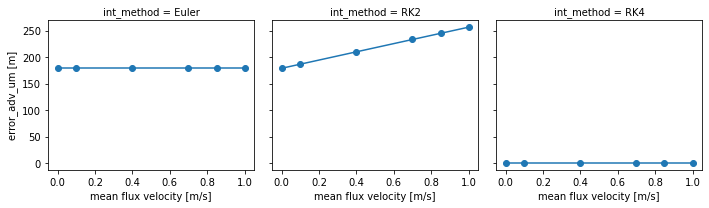

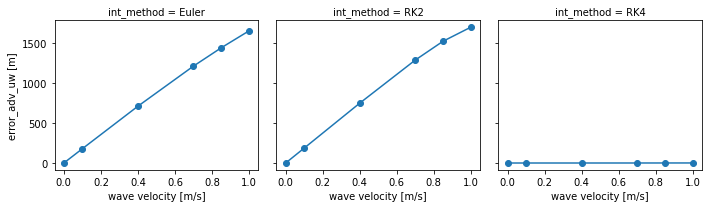

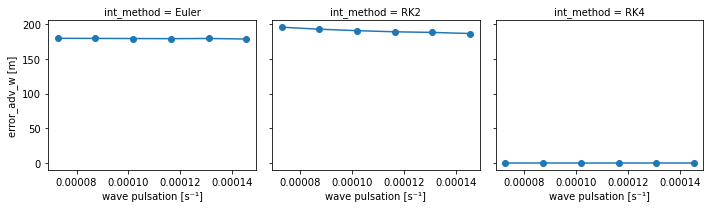

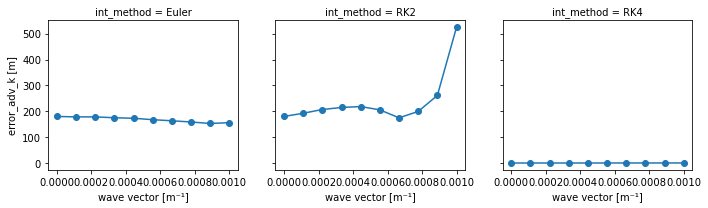

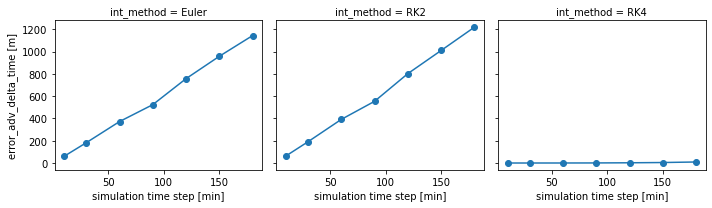

In [3]:
ds.error_adv_um.plot(col='int_method',marker='o')
ds.error_adv_uw.plot(col='int_method',marker='o')
ds.error_adv_w.plot(col='int_method',marker='o')
ds.error_adv_k.plot(col='int_method',marker='o')
ds.error_adv_delta_time.plot( x='delta_t_min',col='int_method',marker='o')

This one shows type of dependency for all:

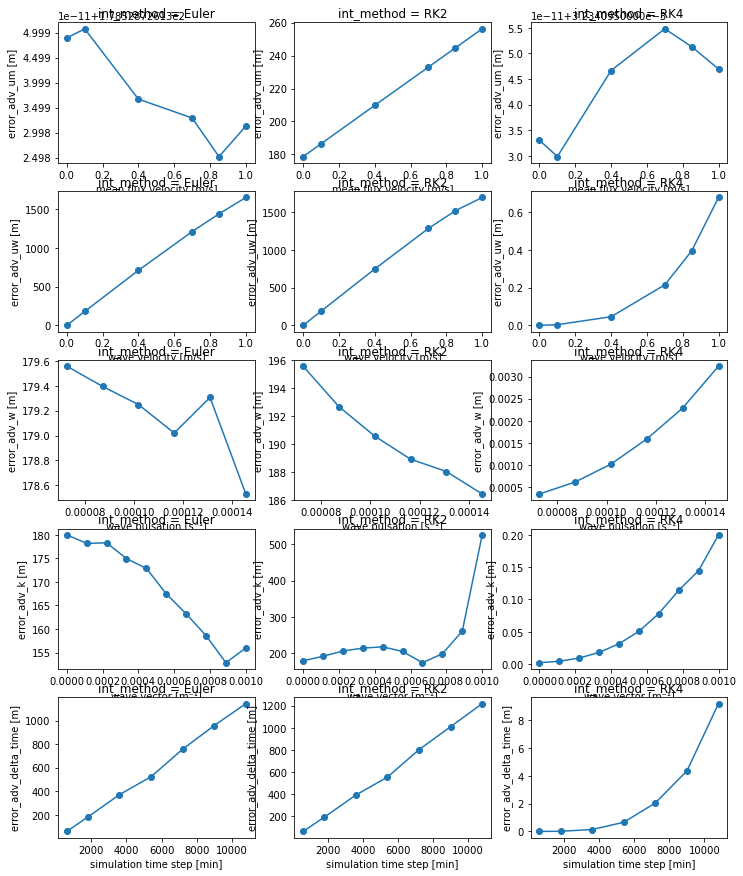

In [44]:
fig, axes = plt.subplots(ncols=3,nrows=5,figsize=(12,15))
method=['Euler','RK2', 'RK4']
for i in range(3):
    ds.error_adv_um.sel(int_method=method[i]).plot(ax=axes[0][i], marker='o')
    ds.error_adv_uw.sel(int_method=method[i]).plot(ax=axes[1][i], marker='o')
    ds.error_adv_w.sel(int_method=method[i]).plot(ax=axes[2][i], marker='o')
    ds.error_adv_k.sel(int_method=method[i]).plot(ax=axes[3][i], marker='o')
    ds.error_adv_delta_time.sel(int_method=method[i]).plot(ax=axes[4][i], marker='o')

And this figure only dependency for RK4 (complemenary to the first one)

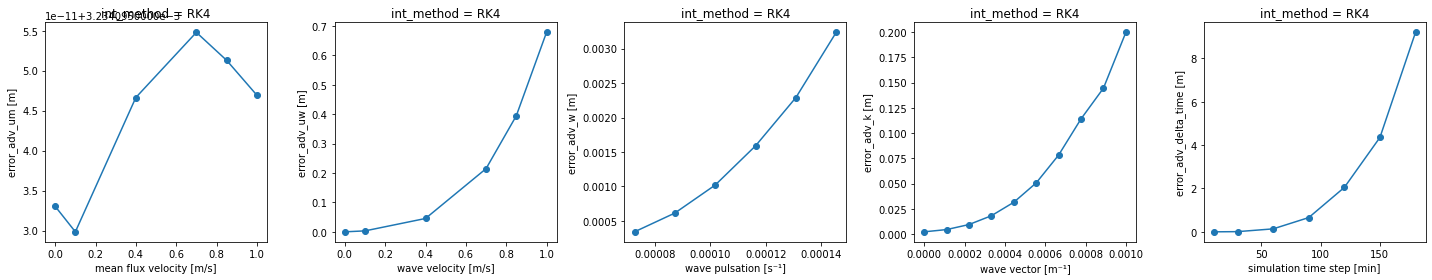

In [45]:
fig, axes = plt.subplots(ncols=5, figsize=(20,4))
ds.error_adv_um.sel(int_method='RK4').plot(marker='o',ax=axes[0])
ds.error_adv_uw.sel(int_method='RK4').plot(marker='o',ax=axes[1])
ds.error_adv_w.sel(int_method='RK4').plot(marker='o',ax=axes[2])
ds.error_adv_k.sel(int_method='RK4').plot(marker='o',ax=axes[3])
ds.error_adv_delta_time.sel(int_method='RK4').plot( x='delta_t_min', marker='o',ax=axes[4])
plt.tight_layout()

plt.draw()

## Observations
* The uw and t_step dependence for Euler method seems linear, as expected
* Error amplitude of RK2 method seems to be more sensitive to mean flux velocity um and wave vector k2, but appears to also have a linear dependance on wave velocity $u_w$ and simulation time step $t_{step}$
* RK4 error amplitude is far smaller than others, and seems to have polynomial or exponential dependency on $u_w, w, k, t_{step}$
* Dependency on $u_m$ for Euler and RK4 can be neglected (10e-11 m )
* Notice that for k=0, the amplitude is around 180 m,the expected value

### Linear regression on advancement ???

In [14]:
comp.reglin_mean_adv()

<xarray.Dataset>
Dimensions:               (degree: 2, int_method: 5)
Coordinates:
  * degree                (degree) int64 1 0
  * int_method            (int_method) object 'Euler' ... 'RK4 10min (referen...
Data variables:
    polyfit_coefficients  (degree, int_method) float64 0.1022 0.1022 ... -0.9063